# Improvements to HierQ

 - Relative Goal Spaces
 - Optional Goal-Conditioning of top-level.

In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

#### Libraries

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

In [3]:
AgentShelve.get_types()

['TabularQLearner',
 'TabularDynaQ',
 'MonteCarloQLearner',
 'RandomAgent',
 'HierQ',
 'HierQV2',
 'HierQTD',
 'HierQTS']

In [4]:
AgentShelve.get_keyword_args('HierQTS')

<Signature (observation_shape: 'typing.Tuple', n_actions: 'int', n_levels: 'int', horizons: 'typing.Union[typing.List[int]]', lr: 'float' = 0.5, epsilon: 'float' = 0.1, discount: 'float' = 0.95, relative_goals: 'bool' = True, universal_top: 'bool' = True, ignore_training_time: 'bool' = False, legal_states: 'np.ndarray' = None, planning_level: 'int' = 1, num_sims: 'int' = 10, c_uct: 'float' = 1.41, temp: 'float' = 1.0, simulator: 'gym.Env' = None) -> 'None'>

In [56]:
t = 500

name_four_rooms = EnvRegister.register(
    maze_type='four_rooms_HierQ', 
    name=f'four_rooms_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[3, 8]]
    ),
    time_limit=t,
    override=True
)

name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=t,
    override=True
)

Warning, room_size and gap_size are best kept as uniformly odd or even, not one odd one even.


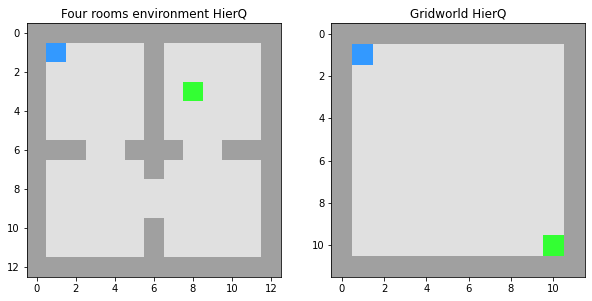

In [57]:
# Instantiate the registered MazeLab environment as a Gym environment.
four_rooms = gym.make(name_four_rooms)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = four_rooms.reset(), gridworld.reset()

img_a, img_b = four_rooms.unwrapped.get_image(), gridworld.unwrapped.get_image()

four_rooms.close()
gridworld.close()

f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_a)
axarr[0].set_title("Four rooms environment HierQ")

axarr[1].imshow(img_b)
axarr[1].set_title("Gridworld HierQ")

plt.show()

In [58]:
# four_rooms.maze.objects.agent.positions[0] = np.asarray([2, 2])
four_rooms.maze.objects.agent.positions[0]
# np.asarray((2, 2))

array([1, 1])

In [74]:
def gen_hierq(n_levels: int, horizon: int, _env: gym.Env, universal_top: bool = True, num_sims: int = 10, simulate: bool = False):
    # Helper function for instantiating a HierQ agent with a fixed environment goal.
    agent = AgentShelve.retrieve(
        agent='HierQTS',
        keyword_arguments=dict(
            observation_shape=_env.observation_space.shape,
            n_actions=_env.action_space.n,
            n_levels=n_levels,
            horizons=[horizon] * (n_levels - 1) + [200],
            lr=1, discount=1, epsilon=0.1, 
            universal_top=universal_top,
            num_sims=num_sims, simulator=(_env.unwrapped.clone() if simulate else None)
        ))
    agent.set_goal(agent._get_index(_env.unwrapped.maze.get_end_pos()[0]))
    return agent


def get_agent_gen(_env_name: str):
    # Wrapper function for instantiating the agent generator with an environment dependency.
    dummy = gym.make(_env_name)
    return [
#         lambda: sim_abs_hierqts_l2_high(_env=dummy),
#         lambda: sim_abs_hierqts_l2(_env=dummy),
        lambda: abs_hierqts_l2_high(_env=dummy),
        lambda: abs_hierqts_l2(_env=dummy),
        lambda: abs_hierq_l2(_env=dummy)
    ]

sim_abs_hierqts_l2_high = partial(gen_hierq, n_levels=2, horizon=2, universal_top=False, num_sims=100, simulate=True)
sim_abs_hierqts_l2 = partial(gen_hierq, n_levels=2, horizon=2, universal_top=False, num_sims=10, simulate=True)

abs_hierqts_l2_high = partial(gen_hierq, n_levels=2, horizon=2, universal_top=False, num_sims=100)
abs_hierqts_l2 = partial(gen_hierq, n_levels=2, horizon=2, universal_top=False, num_sims=10)

abs_hierq_l2 = partial(gen_hierq, n_levels=2, horizon=2, universal_top=False, num_sims=1)

In [75]:
# Benchmark configuration
r = 3
it = 50
eps = 1
trials = 1
verbose = True

# Benchmark data for each agent.
benchmark_data = list()
for env_name in [name_gridworld]:
    
    env_data = list()
    for agent_gen in get_agent_gen(env_name):
        # Run the benchmark
        env_data.append(
            benchmark(
                env_id=env_name, 
                _agent_gen=agent_gen, 
                agent_test_kwargs=dict(behaviour_policy=False),
                agent_train_kwargs=dict(),
                num_repetitions=r,
                num_iterations=it,
                num_episodes=eps,
                num_trials=trials,
                evaluation_hooks=[GenericOuterHook()],
                verbose=verbose,
                asynchronous=False
            )
        )
    benchmark_data.append((env_name, env_data))

-- Benchmarking Repetition 1 / 3 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:59<00:00,  3.58s/it]
-- Benchmarking Repetition 2 / 3 --- ETA: 0:06:01 --- Rate: 180 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [05:34<00:00,  6.69s/it]
-- Benchmarking Repetition 3 / 3 --- ETA: 0:04:20 --- Rate: 260 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [04:55<00:00,  5.90s/it]
-- Benchmarking Repetition 1 / 3 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.40it/s]
-- Benchmarking Repetition 2 / 3 --- ETA: 0:00:30 --- Rate: 15 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.57it/s]
-- Benchmarking Repetition 3 / 3 --- ETA: 0:00:13 --- Rate:

## Plot Results

In [76]:
def plot_progress(arr: np.ndarray, population_size: int, axis: int = 0, label: str = None) -> None:
    # Helper function for plotting.
    mean_length = arr[...,axis][...,0].mean(axis=0)
    std_length = arr[...,axis][...,0].std(axis=0) / np.sqrt(population_size)

    plt.plot(mean_length, label=label, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)
    
    
def manhattan_dist(c_a: np.ndarray, c_b: np.ndarray):
    # Helper function to compute the L1 distance between two arrays.
    return np.sum(np.abs(np.asarray(c_a) - np.asarray(c_b)))

#### Four-Rooms

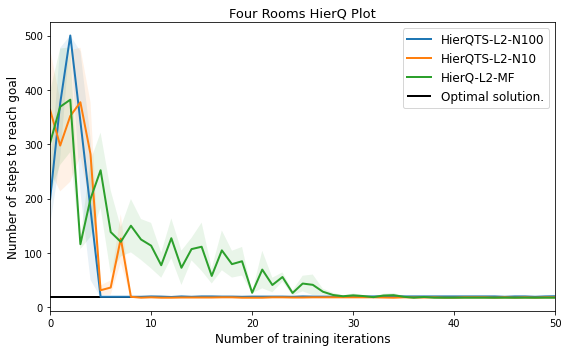

In [77]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'HierQTS-L2-N100', r'HierQTS-L2-N10', r'HierQ-L2-MF']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

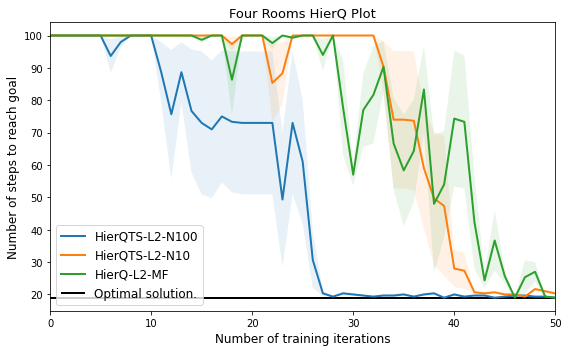

In [45]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'HierQTS-L2-N100', r'HierQTS-L2-N10', r'HierQ-L2-MF']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

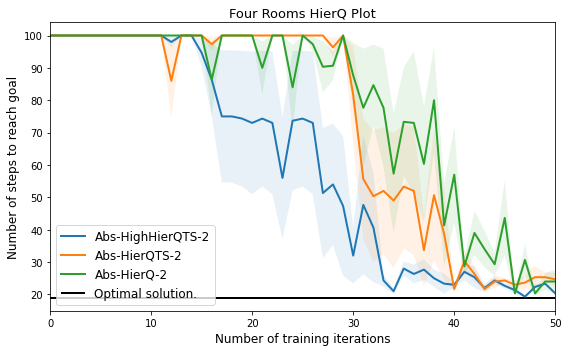

In [42]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[0][1], [r'Abs-HighHierQTS-2', r'Abs-HierQTS-2', r'Abs-HierQ-2']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

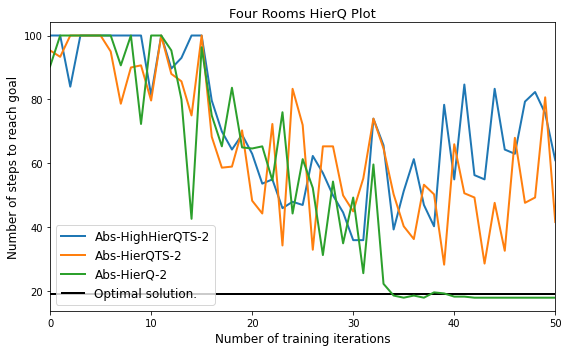

In [65]:
plt.figure(figsize=(8, 5))

for a, l in zip(benchmark_data[1][1], [r'Abs-HighHierQTS-2', r'Abs-HierQTS-2', r'Abs-HierQ-2']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
plt.hlines(19, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("Four Rooms HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

#### GridWorld

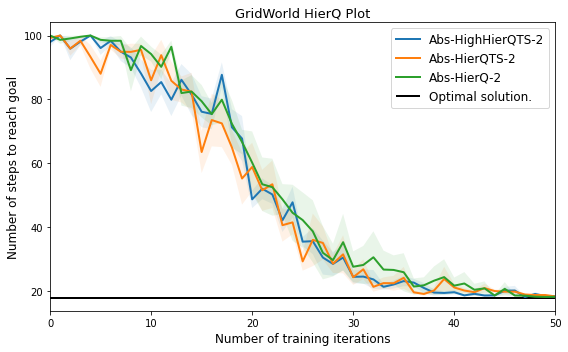

In [97]:
plt.figure(figsize=(8, 5))

x = 2
for a, l in zip(benchmark_data[1][1], [r'Abs-HighHierQTS-2', r'Abs-HierQTS-2', r'Abs-HierQ-2']):
    plot_progress(np.asarray(a), population_size=r, axis=2, label=l)

# Optimal solution on this example is 14 steps.
optimal = manhattan_dist(gridworld.unwrapped.maze.get_start_pos(), gridworld.unwrapped.maze.get_end_pos()[0])
plt.hlines(optimal, 0, 50, label='Optimal solution.', color='black', linewidth=2)

plt.xlim([0, 50])
plt.title("GridWorld HierQ Plot", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()